Good afternoon, and welcome to this data model.
Today we are going to observe how we used draft eligible college basketball data to determine the success a player would have in the NBA.

We have a lot of raw data, our college-stats file contains a deluge of all college players that played between the years 2009-2021, whether they made the NBA or not, and our common_player files and draft_combine files contain data across the entire history of the NBA.

Below, we will start by defining success in the nba. We will have 3 classifications. A player is a star if they made an all star team, which we have compiled manually, a player is solid if they played at least 5 years in the nba (i.e. they were good enough to get a second contract after their rookie contract), and a player is a bust if they played less than 5 years in the NBA.

In [37]:
import pandas as pd
import star_players
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split


def classify_player(row):
    if row['display_first_last'] in (star_players.get_star_players()):
        return 'STAR'
    elif row['to_year'] - row['from_year'] >= 5:
        return 'SOLID'
    else:
        return 'BUST'


Next, we wil perform some preprocessing of the raw data files in order to create a clean dataset that we can use to train our model. We wont go over everything we do in the cleaning process, but essentially, we will apply the classification function above to the data, as well select data that is most significant for analysis. We will display a sample of the data below that should show a good mix of stars, solid players and busts.

In [38]:

college_df = pd.read_csv("college-stats.csv", low_memory=False)

college_df = college_df.loc[college_df.groupby('player_name')['year'].idxmax()]

nba_df = pd.read_csv("common_player_info.csv")
draft_year = 2009

nba_df = nba_df[nba_df["from_year"] >= draft_year]

nba_df.sort_values(by=['from_year'], inplace=True)

nba_df['classification'] = nba_df.apply(classify_player, axis=1)

# We will remove the college players that most recently entered the NBA, as we do not have enough information to determine
# whether they are a bust or a solid player yet.
nba_df = nba_df[
        ~(
            (nba_df['from_year'] >= 2019) &
            (nba_df['to_year'] >= 2023) &
            (nba_df['classification'] == 'BUST')
        )
    ]



columns = ['display_first_last', 'classification', 'from_year', 'to_year', 'school']

nba_df = nba_df[columns]


nba_df.to_csv('output.csv', index=False)




classified__nba_df = pd.read_csv("output.csv")

# Merge college statistics with NBA player names
clean_data = classified__nba_df.merge(college_df, left_on=['display_first_last', 'from_year'], right_on=['player_name', 'year'], how='inner')

# Merge draft combine dataa with NBA player names.
draft_combine = pd.read_csv("draft_combine_stats.csv")
clean_data = clean_data.merge(draft_combine, left_on='display_first_last', right_on='player_name', how='inner')

# transform the year players are into their numerical equivalent
clean_data['yr'] = clean_data['yr'].replace({'Fr': 1, 'So': 2, 'Jr': 3, 'Sr': 4})

# Only select relevant data for model
clean_data = clean_data[star_players.get_training_columns()]
clean_data.to_csv('output.csv', index=False)
clean_data.sample(10)

#


C:\Users\chukw\AppData\Local\Temp\ipykernel_11464\3594199666.py:46: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  clean_data['yr'] = clean_data['yr'].replace({'Fr': 1, 'So': 2, 'Jr': 3, 'Sr': 4})


,display_first_last,classification,GP,Min_per,Ortg,usg,eFG,TS_per,ORB_per,DRB_per,...,ast,stl,blk,pts,height_wo_shoes,height_w_shoes,weight,wingspan,standing_reach,body_fat_pct
105,Kris Joseph,BUST,37,80.3,110.6,21.3,48.6,53.38,5.5,10.8,...,1.5135,1.3514,0.6216,13.4054,78.00,79.00,215.0,83.00,104.0,8.60
50,Evan Turner,SOLID,31,74.4,108.9,34.5,54.0,58.15,7.4,23.5,...,5.9677,1.7419,0.9032,20.3871,77.75,79.00,213.8,80.00,103.5,8.60
263,Semi Ojeleye,BUST,35,85.4,127.5,24.5,57.2,62.15,8.4,15.0,...,1.5143,0.4286,0.4000,19.0000,77.25,78.75,241.4,81.75,102.0,5.50
180,T.J. Warren,SOLID,35,84.8,113.7,33.6,54.8,57.35,10.8,12.8,...,1.1429,1.8000,0.6000,24.8857,79.00,80.25,220.2,82.25,104.0,7.95
148,Tim Hardaway Jr.,SOLID,37,84.2,104.9,22.3,50.4,52.71,0.8,14.5,...,2.4324,0.6757,0.4595,14.2432,76.50,78.25,199.4,79.00,101.0,6.05
2,Ty Lawson,SOLID,34,69.3,133.7,22.7,59.8,65.29,2.3,7.6,...,6.5882,2.1471,0.1471,16.5294,71.25,72.50,196.6,72.75,94.5,6.60
181,Markel Brown,BUST,34,86.4,118.2,22.5,54.1,59.09,3.5,12.9,...,2.9118,1.0000,1.0294,17.1765,74.50,75.50,184.4,80.75,100.0,4.20
66,Kawhi Leonard,STAR,34,79.6,108.7,27.7,46.3,50.78,11.4,25.9,...,2.5588,1.4706,0.5882,15.5588,78.00,79.00,227.4,87.00,106.0,5.40
37,Gordon Hayward,STAR,37,81.2,113.3,24.4,52.7,60.13,7.6,23.4,...,1.6757,1.0811,0.8108,15.4595,78.75,80.00,211.0,79.75,103.0,6.90
256,Damyean Dotson,BUST,32,85.4,125.7,21.2,59.5,61.08,5.0,18.2,...,1.0909,0.9091,0.1515,17.4545,76.50,77.50,205.2,81.00,100.0,5.30


Awesome! we can see that for every player listed, we have their associated statistics and measurements. One final bit of preprocessing will be to remove player names, as our random forest model can only accept numerical input

In [39]:

clean_data = clean_data.drop('display_first_last', axis=1)



Next, we will now look at a visualization that shows the distribution of the three different classifications of NBA players, "stars",
"solid" players, and "busts

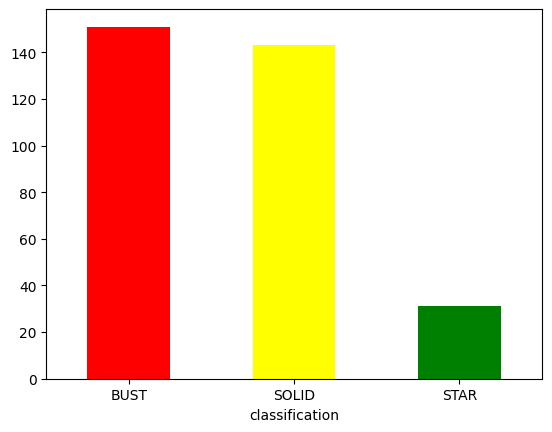

In [40]:
classifications = clean_data.groupby(by='classification').size()
plot = classifications.plot.bar(color=['red', 'yellow','green'],rot=0)


As we can see above, we have relatively even numbers of busts and solid players, with very few star players.

We will now begin the process of training the model, specifically a random forest model.

First, lets split our data into test data and training data. We will need to identify the target result with is the classification of the player, and the independent variables, which are their college statistics and measurements

In [41]:
# identify independent and dependent variables
independentVars = clean_data.drop('classification', axis=1)
dependentVar = clean_data['classification']

training_independent, test_independent, training_dependent, test_depenedent = train_test_split(independentVars, dependentVar, test_size=0.2)

Above we have defined our traiing and test data, as well as isolated the variable (classification) that we want to train our model on.
Actually training the model to a baseline level is quite simple. We will train a random forest model below as well as test it using our designated data.

In [43]:
# create default tree
random_forest = RandomForestClassifier()
random_forest.fit(training_independent, training_dependent)

predictions = random_forest.predict(test_independent)


accuracy = accuracy_score(test_depenedent, predictions)
print(accuracy)


0.5076923076923077
